In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import sklearn

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
train_images = pd.read_csv("/content/drive/MyDrive/machine learning project/machine/csvTrainImages 60k x 784.csv")
train_labels = pd.read_csv("/content/drive/MyDrive/machine learning project/machine/csvTrainLabel 60k x 1.csv")
test_images = pd.read_csv("/content/drive/MyDrive/machine learning project/machine/csvTestImages 10k x 784.csv")
test_labels = pd.read_csv("/content/drive/MyDrive/machine learning project/machine/csvTestLabel 10k x 1.csv")

# add the lables of the dataset
train_images['label'] = train_labels
test_images['label'] = test_labels

print(train_images.shape)
print(test_images.shape)
print(train_images.head())


(59999, 785)
(9999, 785)
   0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.487  0.488  0.489  \
0  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
1  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
2  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
3  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
4  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.490  0.491  0.492  0.493  0.494  0.495  label  
0      0      0      0      0      0      0      1  
1      0      0      0      0      0      0      2  
2      0      0      0      0      0      0      3  
3      0      0      0      0      0      0      4  
4      0      0      0      0      0      0      5  

[5 rows x 785 columns]


In [ ]:
class ImageDataset(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data.iloc[index, self.data.columns != 'label'].values.astype(np.uint8).reshape(28, 28)
        label = self.data.iloc[index, -1]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
train_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
test_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

In [ ]:
train_dataset =ImageDataset(train_images,train_transform)
test_dataset=ImageDataset(test_images,test_transform)

train_idx,val_idx=random_split(train_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
train_list=[train_dataset[i] for i in train_idx.indices]
val_list=[train_dataset[i] for i in val_idx.indices]
image , label = train_dataset.__getitem__(32)
print(type(image))
print(type(label))
image.size()

<class 'torch.Tensor'>
<class 'numpy.int64'>


torch.Size([1, 28, 28])

In [ ]:
#visualization function
def visualize(n,images,labels):
  rows = int(np.sqrt(n))
  cols = int(np.sqrt(n))
  fig, axes = plt.subplots(rows, cols, figsize=(1.5*cols,2*rows))
  for i in range(rows*cols):
    ax = axes[i//cols, i%rows]
    ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap = 'gray')
    ax.set_title('Label: {}'.format(labels[i]))
    ax.axis('off')

In [ ]:
N_IMAGES = 25
train_images = [image for image, label in [train_dataset[i] for i in range(N_IMAGES)]]
train_labels = [label for image, label in [train_dataset[i] for i in range(N_IMAGES)]]

test_images = [image for image, label in [test_dataset[i] for i in range(N_IMAGES)]]
test_labels = [label for image, label in [test_dataset[i] for i in range(N_IMAGES)]]

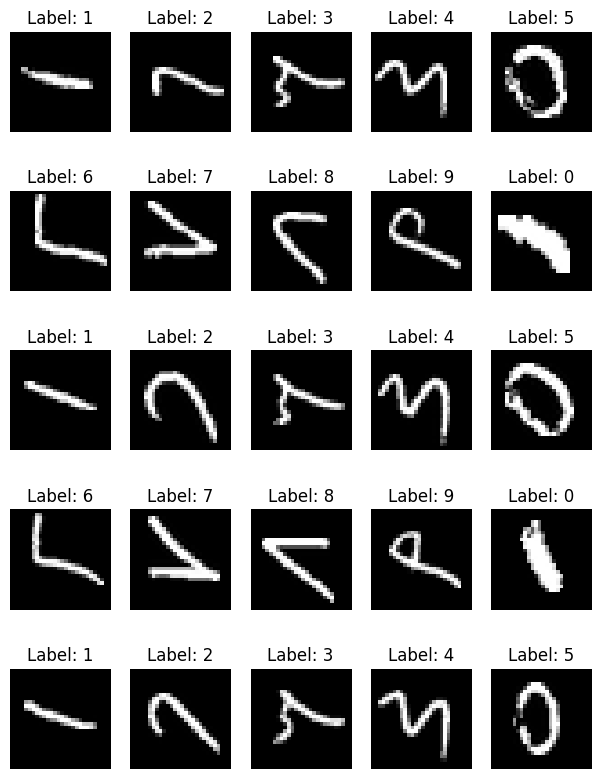

In [ ]:
#visualize a small batch of the training set
visualize(N_IMAGES,train_images,train_labels)

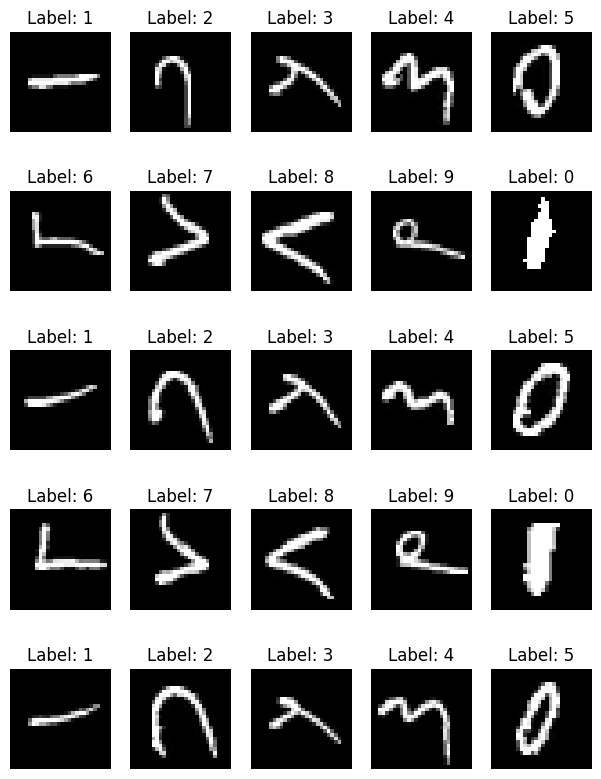

In [ ]:
#visualize a small batch of the training set
visualize(N_IMAGES,test_images,test_labels)

In [ ]:


train_loader= torch.utils.data.DataLoader(train_list ,shuffle = True, batch_size = 128 )
val_loader=torch.utils.data.DataLoader(val_list ,shuffle = True, batch_size = 128  )
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)



In [ ]:
#Model Hyperparameters
RANDOM_SEED = 1 #The seed() method is used to initialize the random number generator. The random number generator needs a number to start with (a seed value), to be able to generate a random number.
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
NUM_EPOCHS = 20

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

In [ ]:
#the model
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))

        x = self.relu(self.batch_norm2(self.conv2(x)))

        x = self.conv3(x)
        x = self.batch_norm3(x)

        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)

        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()


        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x




class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)



def ResNet50(num_classes, channels=1):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

def ResNet101(num_classes, channels=1):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=1):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

In [ ]:
model = ResNet50(10)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function=F.cross_entropy
torch.cuda.empty_cache()

In [ ]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    predicted_labels_2d=[]
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        predicted_labels_2d.append(predicted_labels)
    return (correct_pred.float()/num_examples * 100),predicted_labels_2d

In [ ]:
#training loop
for epoch in range(20):
    # Performing Training for each epoch
    training_loss = 0.
    model.train()
    # The training loop
    for batch in train_loader:
        optimizer.zero_grad()
        input, label = batch
        input = input.to(DEVICE)
        label = label.to(DEVICE)

        output = model(input)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()


    # Performing Validation for each epoch
    validation_loss = 0.
    model.eval()

    # The validation loop
    for batch in val_loader:
        input, label = batch
        input = input.to(DEVICE)
        label = label.to(DEVICE)
        output = model(input)
        loss = loss_function(output, label)
        validation_loss += loss.item()

    # Calculating the average training and validation loss over epoch
    training_loss_avg = training_loss/len(train_loader)
    validation_loss_avg = validation_loss/len(val_loader)
    train_acc,_=compute_accuracy(model, train_loader, device=DEVICE)
    val_acc,_=compute_accuracy(model, val_loader, device=DEVICE)

    # Printing average training and average validation losses
    print("Epoch: {}".format(epoch+1))
    print("Training loss: {}".format(training_loss_avg))
    print("Validation loss: {}".format(validation_loss_avg))
    print('Epoch: %03d/%03d | Train: %.3f%%' % (epoch+1, NUM_EPOCHS, train_acc))
    print('Epoch: %03d/%03d | Val: %.3f%%' % (epoch+1, NUM_EPOCHS, val_acc))

Epoch: 1
Training loss: 0.30447777030865353
Validation loss: 0.08930170059481517
Epoch: 001/020 | Train: 98.596%
Epoch: 001/020 | Val: 97.533%
Epoch: 2
Training loss: 0.057248418483883144
Validation loss: 0.05811516490289347
Epoch: 002/020 | Train: 99.500%
Epoch: 002/020 | Val: 98.275%
Epoch: 3
Training loss: 0.028397817861754448
Validation loss: 0.05495719648798571
Epoch: 003/020 | Train: 99.627%
Epoch: 003/020 | Val: 98.425%
Epoch: 4
Training loss: 0.02198904861265328
Validation loss: 0.06552128823711834
Epoch: 004/020 | Train: 99.308%
Epoch: 004/020 | Val: 98.258%
Epoch: 5
Training loss: 0.01779054728268723
Validation loss: 0.04153084369906363
Epoch: 005/020 | Train: 99.796%
Epoch: 005/020 | Val: 98.875%
Epoch: 6
Training loss: 0.015999810522732635
Validation loss: 0.04379300285314031
Epoch: 006/020 | Train: 99.767%
Epoch: 006/020 | Val: 98.800%
Epoch: 7
Training loss: 0.015154277789096037
Validation loss: 0.05639422033477495
Epoch: 007/020 | Train: 99.527%
Epoch: 007/020 | Val: 98.

In [ ]:
with torch.set_grad_enabled(False): # save memory during inference
    acc,predicted_labels=(compute_accuracy(model, test_loader, device=DEVICE))
    print('Test accuracy: %.2f%%' % acc)

Test accuracy: 98.64%


In [ ]:
N_IMAGES = 25
test_images = [image for image, label in [test_dataset[i] for i in range(N_IMAGES)]]
test_labels = []
e=0
for i in range(len(predicted_labels[0])):
  test_labels.append(predicted_labels[0].cpu().numpy()[i])
  e+=1

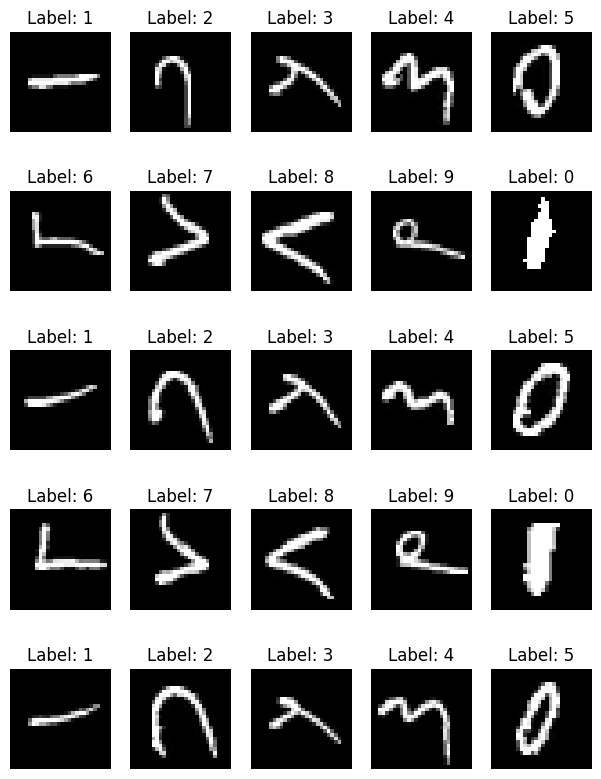

In [ ]:
visualize(N_IMAGES,test_images,test_labels)